In [1]:
from skimage.transform import rotate
from functools import partial
from scipy.linalg.lapack import dsyevr, dsyevd, dgesdd, dgesvd
from trick import downdate, minimal_downdate

In [2]:
def truncate_svd(mtx_x, n_modes):
    '''Compute the SVD X = U S V^T, where S is 
    ordered with greatest singular values first,
    and truncate after the `n_modes` singular value'''
    mtx_u, diag_s, mtx_vt = np.linalg.svd(mtx_x, full_matrices=False)
    mtx_u = mtx_u[:,:n_modes]
    diag_s = diag_s[:n_modes]
    mtx_vt = mtx_vt[:n_modes]
    return mtx_u, diag_s, mtx_vt

In [3]:
def klip(image_cube, n_modes, kl_transformer):
    # reshape
    image_shape = image_cube.shape[1:]
    n_pix = image_shape[0] * image_shape[1]
    n_frames = image_cube.shape[0]
    image_vecs = image_cube.reshape(n_frames, n_pix)
    
    # mean subtract
    mean_vec = np.average(image_vecs, axis=1)
    image_vecs_meansub = image_vecs - mean_vec[:,np.newaxis]
    
    estimated_vecs =  np.zeros_like(image_vecs)
    subtracted_vecs = np.zeros_like(image_vecs)
    indices = np.arange(n_frames)
    for i in indices:
        target = image_vecs_meansub[i]
        reference = image_vecs_meansub[indices != i]
        Z_KL_truncated = kl_transformer(reference, n_modes)
        # subtract starlight
        estimated_vecs[i] = Z_KL_truncated @ (Z_KL_truncated.T @ target)
        subtracted_vecs[i] = target - estimated_vecs[i]
    # reshape back to image
    estimated_images = estimated_vecs.reshape((n_frames,) + image_shape)
    subtracted_images = subtracted_vecs.reshape((n_frames,) + image_shape)
    return estimated_images, subtracted_images

def kl_trans_svd(reference, n_modes, svd_solver):
    u, s, vt = svd_solver(reference)
    return vt.T[:,:n_modes]

def svd_dgesvd(mtx_x):
    u, s, vt, info = dgesvd(
        a=mtx_x,
        full_matrices=False
    )
    if info != 0:
        raise RuntimeError(f"dgesvd info {info}")
    return u, s, vt

kl_trans_dgesvd = partial(kl_trans_svd, svd_solver=svd_dgesvd)

def svd_dgesdd(mtx_x):
    u, s, vt, info = dgesdd(
        a=mtx_x,
        full_matrices=False
    )
    if info != 0:
        raise RuntimeError(f"dgesvd info {info}")
    return u, s, vt

kl_trans_dgesdd = partial(kl_trans_svd, svd_solver=svd_dgesdd)

# kl_trans_npsvd = partial(kl_trans_svd, svd_solver=partial(np.linalg.svd, full_matrices=False))

def kl_trans_covs(reference, n_modes, eig_solver):
    # KL transform
    cov_x = reference @ reference.T
    lambda_values, C = eig_solver(cov_x)
    Z_KL = reference.T @ (C * np.power(lambda_values, -1/2))
    # Truncate
    Z_KL_truncated = Z_KL[:,:n_modes]
    return Z_KL_truncated

def eig_dsyevr(cov_x):
    w, z, m, isuppz, info = dsyevr(
        a=cov_x,
        compute_v=1,
        range='A',
    )
    if info != 0:
        raise RuntimeError("???")
    # sort such that largest eigenvalues/vectors are first
    eigenvalues = np.flip(w)
    eigenvectors = np.flip(z, axis=1)
    return eigenvalues, eigenvectors

kl_trans_dsyevr = partial(kl_trans_covs, eig_solver=eig_dsyevr)

def eig_dsyevd(cov_x):
    w, v, info = dsyevd(
        a=cov_x,
        compute_v=1,
    )
    if info != 0:
        raise RuntimeError("???")
    # sort such that largest eigenvalues/vectors are first
    eigenvalues = np.flip(w)
    eigenvectors = np.flip(v, axis=1)
    return eigenvalues, eigenvectors

kl_trans_dsyevd = partial(kl_trans_covs, eig_solver=eig_dsyevd)

In [4]:
def simple_aperture_locations(r_px, pa_deg, resolution_element_px, 
                              exclude_nearest=0, exclude_planet=False):
    '''Generator yielding aperture centers (x, y) in a ring of radius `r_px`
    and starting at angle `pa_deg` E of N. Unless `exclude_planet` is True,
    the first (x, y) pair gives the planet location (signal aperture).
    
    Specifying `exclude_nearest` > 0 will skip that many apertures 
    from either side of the signal aperture's location'''
    circumference = 2 * r_px * np.pi
    aperture_pixel_diameter = resolution_element_px
    n_apertures = int(circumference / aperture_pixel_diameter)
    start_theta = np.deg2rad(pa_deg + 90)
    delta_theta = np.deg2rad(360 / n_apertures)
    if not exclude_planet:
        yield (r_px * np.cos(start_theta),
               r_px * np.sin(start_theta))
    for i in range(1 + exclude_nearest, n_apertures - exclude_nearest):
        offset_x, offset_y = (
            r_px * np.cos(start_theta + i * delta_theta),
            r_px * np.sin(start_theta + i * delta_theta)
        )
        yield offset_x, offset_y

In [5]:
def show_simple_aperture_locations(image, resolution_element_px, r_px, pa_deg, 
                                   exclude_nearest=0, exclude_planet=False, ax=None):
    '''Plot `image` and overplot the circular apertures of diameter 
    `resolution_element_px` in a ring at radius `r_px`
    starting at `pa_deg` E of N.
    '''
    if ax is None:
        ax = plt.gca()
    ctr = (image.shape[0] - 1) / 2
    im = ax.imshow(image)
    dd.add_colorbar(im)
    ax.axhline(ctr, color='w', linestyle=':')
    ax.axvline(ctr, color='w', linestyle=':')
    planet_dx, planet_dy = r_px * np.cos(np.deg2rad(90 + pa_deg)), r_px * np.sin(np.deg2rad(90 + pa_deg))
    ax.arrow(ctr, ctr, planet_dx, planet_dy, color='w', lw=2)
    for offset_x, offset_y in simple_aperture_locations(r_px, pa_deg, resolution_element_px, exclude_nearest=exclude_nearest, exclude_planet=exclude_planet):
        ax.add_artist(plt.Circle(
            (ctr + offset_x, ctr + offset_y),
            radius=resolution_element_px/2,
            edgecolor='orange',
            facecolor='none',
        ))

In [6]:
def cartesian_coords(center, data_shape):
    '''center in x,y order; returns coord arrays xx, yy of data_shape'''
    yy, xx = np.indices(data_shape, dtype=float)
    center_x, center_y = center
    yy -= center_y
    xx -= center_x
    return xx, yy

In [7]:
def reduce_apertures(image, r_px, starting_pa_deg, resolution_element_px, operation, 
                     exclude_nearest=0, exclude_planet=False):
    '''apply `operation` to the pixels within radius `resolution_element_px`/2 of the centers
    of the simple aperture locations for a planet at `r_px` and `starting_pa_deg`, returning
    the locations and the results as a tuple with the first location and result corresponding
    to the planet aperture'''
    center = (image.shape[0] - 1) / 2, (image.shape[0] - 1) / 2
    xx, yy = cartesian_coords(center, image.shape)
    locations = list(simple_aperture_locations(r_px, starting_pa_deg, resolution_element_px, exclude_nearest=exclude_nearest, exclude_planet=exclude_planet))
    simple_aperture_radius = resolution_element_px / 2
    results = []
    for offset_x, offset_y in locations:
        dist = np.sqrt((xx - offset_x)**2 + (yy - offset_y)**2)
        mask = dist <= simple_aperture_radius
        results.append(operation(image[mask] / np.count_nonzero(mask & np.isfinite(image))))
    return locations, results

def calc_snr_mawet(signal, noises):
    '''Calculate signal to noise following the 
    two-sample t test as defined in Mawet 2014'''
    return (
        signal - np.average(noises)
    ) / (
        np.std(noises) * np.sqrt(1 + 1/len(noises))
    )

In [8]:
def derotate(image_cube, angles):
    derotated_image = np.zeros(image_cube.shape[1:])
    for i in range(image_cube.shape[0]):
        derotated_image += rotate(image_cube[i], -angles[i])
    return derotated_image

In [9]:
# !curl -OL https://github.com/carlgogo/VIP_extras/raw/master/datasets/naco_betapic_preproc.npz

In [10]:
naco_betapic_preproc = np.load('./naco_betapic_preproc.npz')
image_cube = naco_betapic_preproc['cube']
image_shape = image_cube.shape[1:]
n_pix = image_shape[0] * image_shape[1]
n_frames = image_cube.shape[0]
angles = naco_betapic_preproc['angles']

In [42]:
def diagnostic(image_cube, n_modes, reducer, hist_bins=100, name=''):
    star_cube, klip_cube = reducer(image_cube, n_modes)
    final_image = derotate(klip_cube, angles)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 4))
    ax1.plot(np.std(star_cube - image_cube, axis=(1,2)))
    ax1.set(
        xlabel='Frame #',
        ylabel='Standard Deviation of\n(Estimate) - (Original Data)',
        ylim=(0, 6)
    )
    ax1.grid()
    show_simple_aperture_locations(
        final_image, 
        fwhm_naco,
        r_px, 
        pa_deg, 
        exclude_planet=True, 
        exclude_nearest=1,
        ax=ax2
    )
    ax3.hist(final_image.flat, bins=hist_bins)
    ax3.set(xlabel='Pixel value', ylabel='# in bin')
    ax3.grid()
    loations, results = reduce_apertures(
        final_image,
        r_px,
        pa_deg,
        fwhm_naco,
        np.sum
    )
    planet_signal, noise_measurements = results[0], results[1:]
    ax3.axvline(planet_signal, c='C1', label='Avg. Pixel in Signal Aper.')
    ax3.legend()
    fig.suptitle(name + ' SNR = {:1.3}'.format(calc_snr_mawet(planet_signal, noise_measurements)))
    return star_cube, klip_cube, final_image

In [43]:
fwhm_naco = 4

# show crosshairs on planet
planet_x, planet_y = 62, 63

# convert to r and degrees E of N (CCW from +Y)
ctr = (image_shape[0] - 1) / 2
planet_dx, planet_dy = planet_x - ctr, planet_y - ctr
r_px, pa_deg = (
    np.hypot(planet_dx, planet_dy),
    np.rad2deg(np.arctan2(planet_dy, planet_dx)) - 90
)
r_px, pa_deg

(18.398369492974098, -42.797401838234194)

In [44]:
default_n_modes = 30

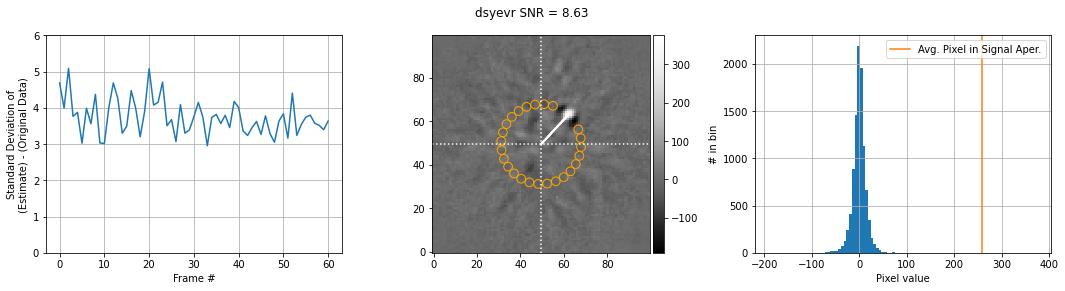

In [45]:
dsyevr_star_cube, dsyevr_klip_cube, dsyevr_final = diagnostic(
    image_cube,
    default_n_modes,
    partial(klip, kl_transformer=kl_trans_dsyevr),
    name='dsyevr'
)

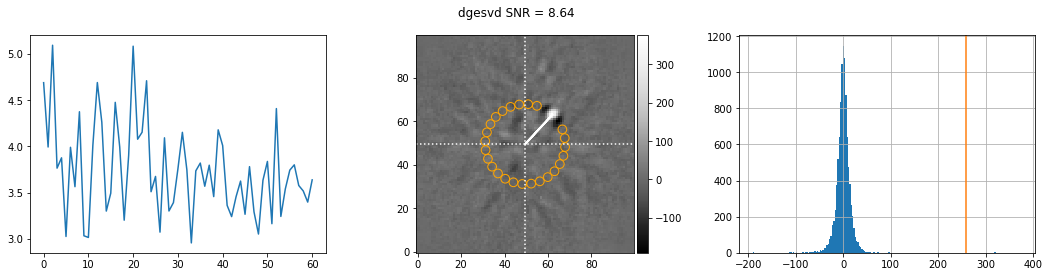

In [14]:
dgesvd_star_cube, dgesvd_klip_cube, dgesvd_final = diagnostic(
    image_cube,
    default_n_modes,
    partial(klip, kl_transformer=kl_trans_dgesvd),
    name='dgesvd'
)

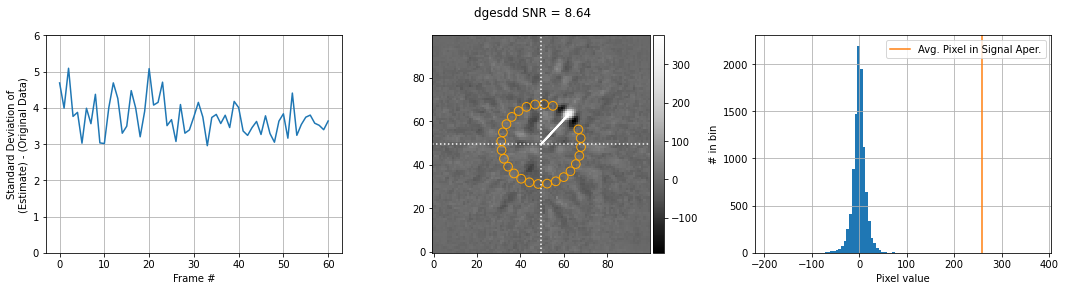

In [46]:
dgesdd_star_cube, dgesdd_klip_cube, dgesdd_final = diagnostic(
    image_cube,
    default_n_modes,
    partial(klip, kl_transformer=kl_trans_dgesdd),
    name='dgesdd'
)

<AxesSubplot:title={'center':'dsyevr'}>

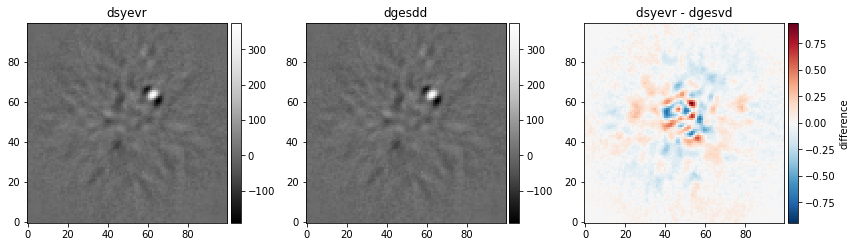

In [61]:
fig, axes = dd.three_panel_diff_plot(
    dsyevr_final, dgesdd_final,
    as_percent=False,
    title_a='dsyevr',
    title_b='dgesdd',
    title_diff='dsyevr - dgesvd'
)
axes[0]

In [51]:
import doodads as dd

In [66]:
def klip_downdate(image_cube, n_modes, kl_transformer):
    # reshape
    image_shape = image_cube.shape[1:]
    n_pix = image_shape[0] * image_shape[1]
    n_frames = image_cube.shape[0]
    image_vecs = image_cube.reshape(n_frames, n_pix).T # note transpose
    
    # mean subtract
    mean_vec = np.average(image_vecs, axis=1)
    image_vecs_meansub = image_vecs - mean_vec[:,np.newaxis]
    
    # init svd
    full_u, full_s, full_vt = truncate_svd(image_vecs_meansub, n_modes)
    full_v = full_vt.T
    
    estimated_vecs =  np.zeros_like(image_vecs)
    subtracted_vecs = np.zeros_like(image_vecs)
    indices = np.arange(n_frames)
    for i in indices:
        target = image_vecs_meansub[:,i]
        reference = image_vecs_meansub[:,indices != i]
#         Z_KL_truncated = kl_transformer(reference.T, n_modes)
        new_u, new_s, new_v = minimal_downdate(
            full_u,
            full_s,
            full_v,
            col_data_to_remove=target.reshape(-1,1),
            col_idxs_to_remove=np.array([i])
        )
        Z_KL_truncated = new_u
        # subtract starlight
        estimated_vecs[:,i] = Z_KL_truncated @ (Z_KL_truncated.T @ target)
        subtracted_vecs[:,i] = target - estimated_vecs[:, i]
    # reshape back to image
    estimated_images = (estimated_vecs + mean_vec[:,np.newaxis]).T.reshape((n_frames,) + image_shape)
    subtracted_images = subtracted_vecs.T.reshape((n_frames,) + image_shape)
    return estimated_images, subtracted_images

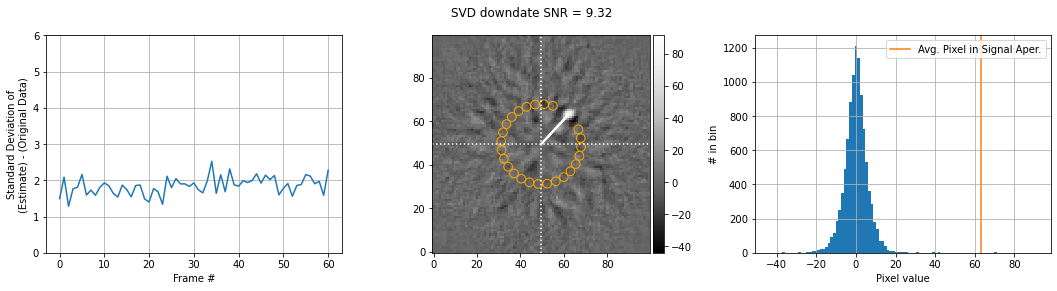

In [68]:
mdd_star_cube, mdd_klip_cube, mdd_final = diagnostic(
    image_cube,
    default_n_modes,
    partial(klip_downdate, kl_transformer=kl_trans_dgesdd),
    name='SVD downdate'
)

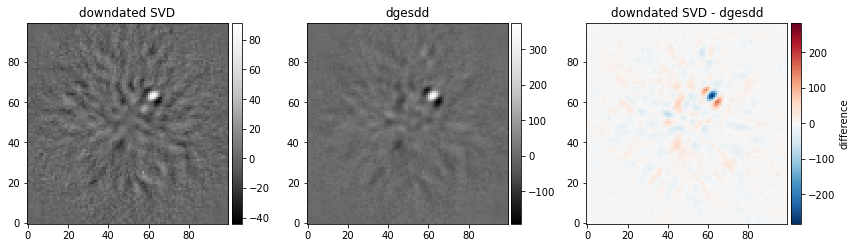

In [69]:
fig, axes = dd.three_panel_diff_plot(
    mdd_final, dgesdd_final,
    as_percent=False,
    title_a='downdated SVD',
    title_b='dgesdd',
    title_diff='downdated SVD - dgesdd'
)